# Preproccessing Data

### Import Dataset

In [1]:
import matplotlib.pyplot as plt 
import numpy as np
from nltk.tokenize import word_tokenize
import re
import pandas as pd
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import string
from wordcloud import WordCloud, STOPWORDS

In [2]:
df = pd.read_csv("reviews.csv")

df.head(5)

,Time_submitted,Review,Rating,Total_thumbsup,Reply
0,2022-07-09 15:00:00,"Great music service, the audio is high quality...",5,2,NaN
1,2022-07-09 14:21:22,Please ignore previous negative rating. This a...,5,1,NaN
2,2022-07-09 13:27:32,"This pop-up ""Get the best Spotify experience o...",4,0,NaN
3,2022-07-09 13:26:45,Really buggy and terrible to use as of recently,1,1,NaN
4,2022-07-09 13:20:49,Dear Spotify why do I get songs that I didn't ...,1,1,NaN


In [3]:
df.Rating.value_counts()

Rating
5    22095
1    17653
4     7842
2     7118
3     6886
Name: count, dtype: int64

### Feature Selection

In [4]:
df.drop(columns=["Time_submitted", "Total_thumbsup", "Reply"], inplace=True)

df.head()

,Review,Rating
0,"Great music service, the audio is high quality...",5
1,Please ignore previous negative rating. This a...,5
2,"This pop-up ""Get the best Spotify experience o...",4
3,Really buggy and terrible to use as of recently,1
4,Dear Spotify why do I get songs that I didn't ...,1


In [5]:
df = df[(df.Rating == 1) | (df.Rating == 5)]

df.head()

,Review,Rating
0,"Great music service, the audio is high quality...",5
1,Please ignore previous negative rating. This a...,5
3,Really buggy and terrible to use as of recently,1
4,Dear Spotify why do I get songs that I didn't ...,1
6,I love the selection and the lyrics are provid...,5


In [6]:
labels = [0 if rate == 1 else 1 for rate in df.Rating]
df["Labels"] = labels

df.head()

,Review,Rating,Labels
0,"Great music service, the audio is high quality...",5,1
1,Please ignore previous negative rating. This a...,5,1
3,Really buggy and terrible to use as of recently,1,0
4,Dear Spotify why do I get songs that I didn't ...,1,0
6,I love the selection and the lyrics are provid...,5,1


In [7]:
df = pd.concat([df[df.Labels == 0].iloc[:3000], df[df.Labels == 1].iloc[:3000]]).sample(frac=1, random_state=42).reset_index(drop=True)

df

,Review,Rating,Labels
0,Had a 160 hour playlist before I got a free tr...,1,0
1,Update:- Thank You Spotify For Resolving below...,5,1
2,Worst song app because it's have an add in bet...,1,0
3,Enjoy the next 30 minutes free from advertisin...,1,0
4,Thanks for bring all good music together,5,1
...,...,...,...
5995,Look they asked nicely and I decided to rate i...,5,1
5996,I love how this works. It's smooth and I know ...,5,1
5997,Very nice app to lessen songs on own choice 👍,5,1
5998,Great app for listening to UT favorite music,5,1


### Duplicated Data

In [8]:
df[df.duplicated()]

,Review,Rating,Labels
765,Too much ads,1,0
1356,Too many ads,1,0
1696,I love Spotify!,5,1
1824,Great app tons of music,5,1
1829,Too many adds,1,0
1989,Too much ads,1,0
2157,Too many ads,1,0
2656,Too many adds,1,0
3613,Too many ads,1,0
3681,Too many ads,1,0


In [9]:
df.drop_duplicates(inplace=True)

df[df.duplicated()]

,Review,Rating,Labels


### Missing Value

In [10]:
df.isna().sum()

Review    0
Rating    0
Labels    0
dtype: int64

In [11]:
df.isnull().sum()

Review    0
Rating    0
Labels    0
dtype: int64

### Train Test Split

In [12]:
def Train_Test_Split(x, y, test_size=0.2, random_seed=None):
    n = len(x)
    if random_seed:
        np.random.seed(random_seed)

    test_size = int(test_size*n)
    indices = np.random.permutation(n)
    train_indices, test_indices = indices[test_size:], indices[:test_size]
    return x.iloc[train_indices], x.iloc[test_indices], y.iloc[train_indices], y.iloc[test_indices]

X_train, X_test, y_train, y_test = Train_Test_Split(df.Review, df.Labels, test_size=0.2, random_seed=42)

In [13]:
X_train

4574    Can you stop shaming people for not taking you...
1886    (26/06/21) App used to be really good but now ...
2843       Good compilation of my type of music selection
4107    i don't like the update of spotify, when i log...
1174               Awesome experience but add is annoying
                              ...                        
3782                    Brilliant especially on Bluetooth
5214    I love this premium feature but in our country...
5249    Every time i wanna play a song. It plays the w...
5414    ILY SPOTIFY. You're the best thing istg. The l...
861                        Multiple ads every 10 minutes.
Name: Review, Length: 4780, dtype: object

### Case Folding

In [14]:
def case_folding(text):
    text = re.sub(r"@[A-Za-z0-9_]+", "", text)
    text = re.sub(r"#\w+", "", text)
    text = re.sub(r"\d+", "", text)
    text = re.sub(r"RT[\s]+", "", text)
    text = re.sub(r"https?://\S+", "", text)
    text = text.translate(str.maketrans("", "", string.punctuation))

    return text

X_train = X_train.apply(case_folding).str.lower()

X_train.head()

4574    can you stop shaming people for not taking you...
1886     app used to be really good but now since the ...
2843       good compilation of my type of music selection
4107    i dont like the update of spotify when i log i...
1174               awesome experience but add is annoying
Name: Review, dtype: object

In [15]:
X_train[32], y_train[32]

('have good music listen to it and u can shut off ur phone and it still plays even when sleeping',
 1)

### Tokenized

In [16]:
tokenized = X_train.apply(lambda x: word_tokenize(x))

tokenized.head(7)

4574    [can, you, stop, shaming, people, for, not, ta...
1886    [app, used, to, be, really, good, but, now, si...
2843    [good, compilation, of, my, type, of, music, s...
4107    [i, dont, like, the, update, of, spotify, when...
1174        [awesome, experience, but, add, is, annoying]
5775    [not, able, to, buy, premium, through, the, ap...
4537    [wonderful, can, have, your, music, played, in...
Name: Review, dtype: object

### Stopwords

In [17]:
stops = set(stopwords.words('english'))

tokenized = tokenized.apply(lambda text: [word for word in text if word not in stops])

tokenized.head(10)


4574    [stop, shaming, people, taking, premium, fine,...
1886    [app, used, really, good, since, updates, keep...
2843          [good, compilation, type, music, selection]
4107    [dont, like, update, spotify, log, gon, na, pl...
1174                 [awesome, experience, add, annoying]
5775                   [able, buy, premium, app, browser]
4537    [wonderful, music, played, automobile, bluetoo...
945     [love, app, absolute, 💯, best, music, streamin...
5367    [love, music, love, layout, love, eveything, i...
4260    [dont, want, see, shows, try, episodes, podcas...
Name: Review, dtype: object

### Stemming

In [18]:
stemmer = PorterStemmer()

tokenized = tokenized.apply(lambda text: [stemmer.stem(token) for token in text])

tokenized.head()

4574    [stop, shame, peopl, take, premium, fine, ad, ...
1886    [app, use, realli, good, sinc, updat, keep, te...
2843                  [good, compil, type, music, select]
4107    [dont, like, updat, spotifi, log, gon, na, pla...
1174                         [awesom, experi, add, annoy]
Name: Review, dtype: object

In [19]:
tokenized[3]

['enjoy',
 'next',
 'minut',
 'free',
 'advertis',
 'songadadadadsongadadsongsongad',
 'pior',
 'premium',
 'user',
 'due',
 'excess',
 'bug',
 'podcast',
 'issu',
 'chosen',
 'discontinu',
 'pay',
 'premium',
 'account',
 'probabl',
 'find',
 'altern',
 'servic']

# Pembobotan Kata

### Analisis Melalui wordcloud

In [20]:
labeled_data = pd.DataFrame(tokenized)
labeled_data["Labels"] = y_train.to_list()

labeled_data.head()

,Review,Labels
4574,"[stop, shame, peopl, take, premium, fine, ad, ...",0
1886,"[app, use, realli, good, sinc, updat, keep, te...",0
2843,"[good, compil, type, music, select]",1
4107,"[dont, like, updat, spotifi, log, gon, na, pla...",0
1174,"[awesom, experi, add, annoy]",1


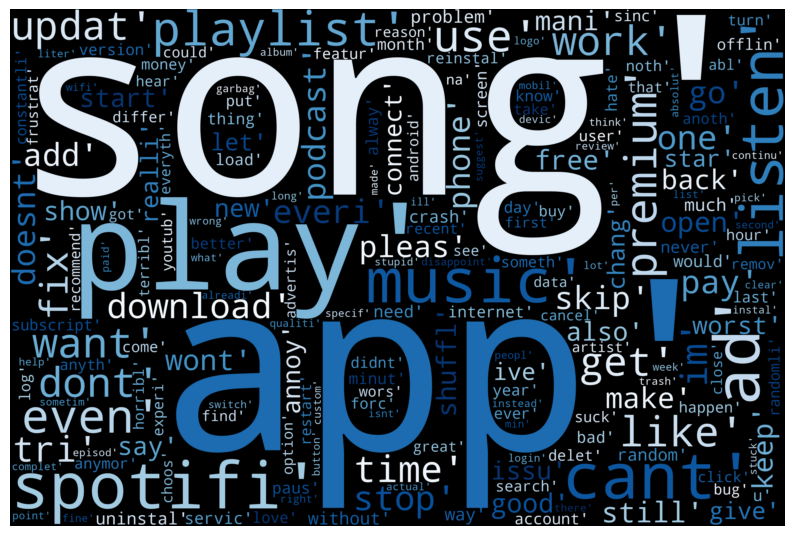

In [21]:
def plot_cloud(word_cloud):
    plt.figure(figsize=(10, 8))
    plt.imshow(word_cloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

all_word = ''.join([str(word) for word in labeled_data.Review[labeled_data.Labels == 0]])

wordcloud = WordCloud(
    width=3000,
    height=2000,
    random_state=3,
    background_color='black',
    colormap="Blues_r",
    collocations=False,
    stopwords=STOPWORDS
).generate(all_word)

plot_cloud(wordcloud)

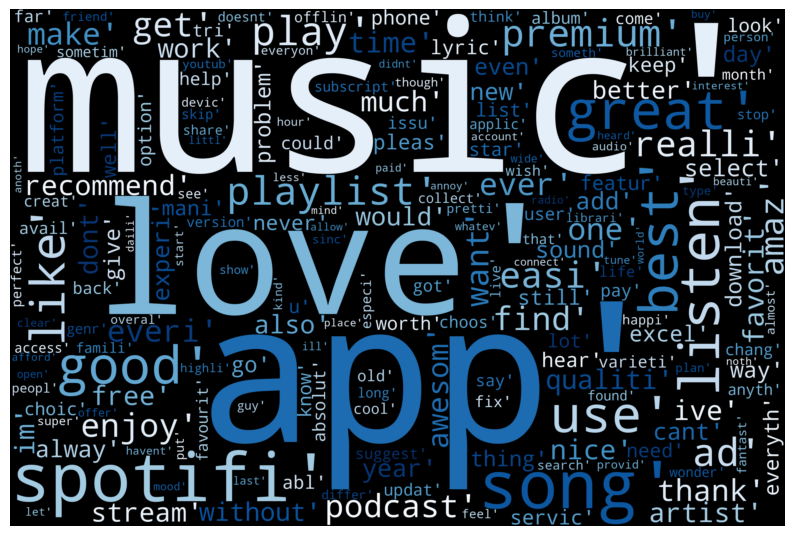

In [22]:
def plot_cloud(word_cloud):
    plt.figure(figsize=(10, 8))
    plt.imshow(word_cloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

all_word = ''.join([str(word) for word in labeled_data.Review[labeled_data.Labels == 1]])

wordcloud = WordCloud(
    width=3000,
    height=2000,
    random_state=3,
    background_color='black',
    colormap="Blues_r",
    collocations=False,
    stopwords=STOPWORDS
).generate(all_word)

plot_cloud(wordcloud)

### Frequency of Word

In [24]:
# sentences = []
word_set = []

for sent in tokenized:
    for word in sent:
        if word not in word_set:
            word_set.append(word)

word_set = set(word_set)
total_document = len(tokenized)

index_dict = {}
i = 0
for word in word_set:
    index_dict[word] = i
    i += 1

In [25]:
def count_dict(senteces): 
    word_count = {}
    for word in word_set:
        word_count[word] = 0
        for sent in tokenized:
            if word in sent:
                word_count[word] += 1
    return word_count

word_count = count_dict(tokenized)
word_count

{'cater': 1,
 'bozo': 1,
 'adress': 1,
 'blah': 1,
 'appgreat': 1,
 'bluetooth': 33,
 '💕💕💕': 1,
 '🤪': 1,
 'woundsit': 1,
 'appsmooth': 1,
 'ppl': 2,
 'trapland': 1,
 'room': 4,
 'gripe': 1,
 'await': 2,
 'hangama': 1,
 '🥺🥺': 2,
 'therefor': 1,
 'invit': 1,
 'mix': 22,
 'flawless': 1,
 'occupi': 1,
 'jelli': 2,
 '😂😂😂': 1,
 'enjoy': 165,
 'you😍😍😍😍': 1,
 'sing': 16,
 'expos': 2,
 'detest': 1,
 'context': 1,
 'fyi': 1,
 'wonder': 35,
 'fish': 2,
 'convert': 2,
 'smoothli': 4,
 'unisntalledreinstal': 1,
 'yesterday': 8,
 'reciev': 3,
 'bail': 1,
 'spanish': 4,
 'uh': 3,
 'than': 1,
 'promotions🥵': 1,
 'darn': 1,
 'expectedtot': 1,
 'tiktok': 1,
 'italian': 1,
 'marxist': 1,
 'rune': 1,
 'vanc': 1,
 'compon': 1,
 'credit': 8,
 'ae': 1,
 'algorithm': 8,
 'amazingli': 1,
 'sli': 1,
 'therapi': 4,
 'possess': 1,
 'artwork': 1,
 'plsypaus': 1,
 'wonki': 1,
 'soy': 1,
 'slider': 1,
 'dint': 2,
 'oop': 4,
 'episod': 32,
 'indonesia': 1,
 'whether': 10,
 'ballan': 1,
 'nobodi': 2,
 'vinyl': 2,
 'er

### Term Frequncy

### Inverse Document Frequency

### TF-IDF

# Modeling dan Testing

### Pembuatan class

### Training

### Testing

### Conclusion